Lib import

In [765]:
# import lib
import pandas as pd
import os
import matplotlib.pyplot as plt
import morton
import glob
from scipy.fft import fft,fftfreq
import numpy as np
import seaborn as sb
import math
from itertools import product



Scenario Identifier

Data translator

Use reference roundabout data for now.

In [766]:
SNOW_FOX_REFERENCE_METADATA = 'SnowFox-Roundabout-Dataset/SnowFox-Roundabout-Dataset/reference-roundabout/reference-roundabout.meta.csv'
SNOW_FOX_REFERENCE_GPS_20 ='SnowFox-Roundabout-Dataset/SnowFox-Roundabout-Dataset/reference-roundabout/reference-roundabout.GPS-20Hz.csv'
SNOW_FOX_REFERENCE_SPEED_100 ='SnowFox-Roundabout-Dataset/SnowFox-Roundabout-Dataset/reference-roundabout/reference-roundabout.Speed-100Hz.csv'
SNOW_FOX_REFERENCE_IMU_100 ='SnowFox-Roundabout-Dataset/SnowFox-Roundabout-Dataset/reference-roundabout/reference-roundabout.Vehicle-IMU-Acceleration-100Hz.csv'

In [767]:
def load_GPS_and_Plot_trace(fileName,key1,key2):
    df = pd.read_csv(fileName, sep=';', usecols = [key1,key2])
    plt.scatter(x=df[key1],y=df[key2])
    plt.title('trace plot with GPS data')



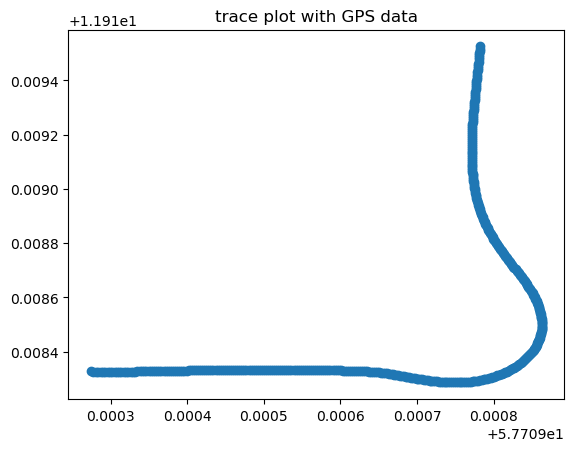

In [768]:
load_GPS_and_Plot_trace(SNOW_FOX_REFERENCE_METADATA,'lat','lon')

In [769]:
def load_Speed_and_IMU_then_calculate_and_plot(speedFile,IMUFile,speed_key,IMU_key1,IMU_key2):
    speed_df=pd.read_csv(speedFile, sep=';', usecols = ['sampleTimeStamp.seconds','sampleTimeStamp.microseconds',speed_key])
    speed_df['ts'] = (speed_df['sampleTimeStamp.seconds']*1000000)+speed_df['sampleTimeStamp.microseconds']
    speed_df=speed_df.drop(columns=['sampleTimeStamp.seconds', 'sampleTimeStamp.microseconds'])
    imu_df= pd.read_csv(IMUFile, sep=';', usecols = ['sampleTimeStamp.seconds','sampleTimeStamp.microseconds',IMU_key1,IMU_key2])
    imu_df['ts'] = (imu_df['sampleTimeStamp.seconds']*1000000)+imu_df['sampleTimeStamp.microseconds']
    imu_df=imu_df.drop(columns=['sampleTimeStamp.seconds', 'sampleTimeStamp.microseconds'])
    result_df=speed_df.merge(imu_df,'outer','ts')
    # result_df.plot(x='ts',y=[speed_key,IMU_key1,IMU_key2])
    return result_df


In [770]:
def load_Speed_and_IMU_From_MetaDATA_then_calculate_and_plot(fileName,speed_key,IMU_key1,IMU_key2,ts_key):
    df=pd.read_csv(fileName, sep=';', usecols =[ts_key,speed_key,IMU_key1,IMU_key2])
    # df.plot(x=ts_key,y=[speed_key,IMU_key1,IMU_key2])
    return df

In [771]:
metadf=load_Speed_and_IMU_From_MetaDATA_then_calculate_and_plot(SNOW_FOX_REFERENCE_METADATA,'groundSpeed','IMULatAcceleration','IMULgtAcceleration','sample_ts')

In [772]:
oridf=load_Speed_and_IMU_then_calculate_and_plot(SNOW_FOX_REFERENCE_SPEED_100,SNOW_FOX_REFERENCE_IMU_100,'groundSpeed','IMULatAcceleration','IMULgtAcceleration')


          sample_ts  groundSpeed  IMULatAcceleration  IMULgtAcceleration
count  7.744000e+03  2093.000000         2092.000000         2092.000000
mean   1.584853e+15     6.735675            0.448598           -0.010068
std    6.057417e+06     1.135311            1.385922            0.328284
min    1.584853e+15     5.466180           -1.921000           -0.722500
25%    1.584853e+15     5.935380           -0.722500           -0.229500
50%    1.584853e+15     6.345930            0.178500           -0.025500
75%    1.584853e+15     7.049730            1.700000            0.178500
max    1.584853e+15     9.904030            3.102500            1.530000
       groundSpeed            ts  IMULatAcceleration  IMULgtAcceleration
count  2093.000000  4.185000e+03         2092.000000         2092.000000
mean      6.735675  1.584853e+15            0.448598           -0.010068
std       1.135311  6.056671e+06            1.385922            0.328284
min       5.466180  1.584853e+15           -1.92100

<Axes: xlabel='sample_ts'>

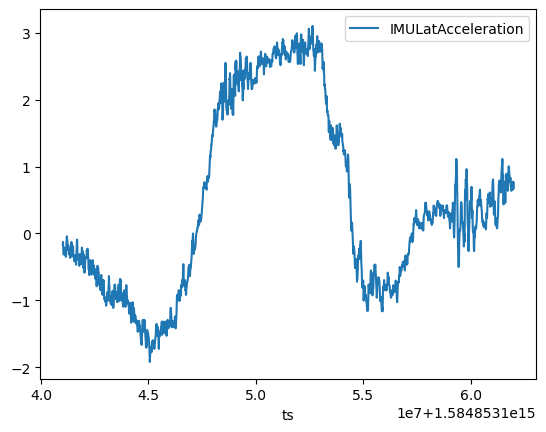

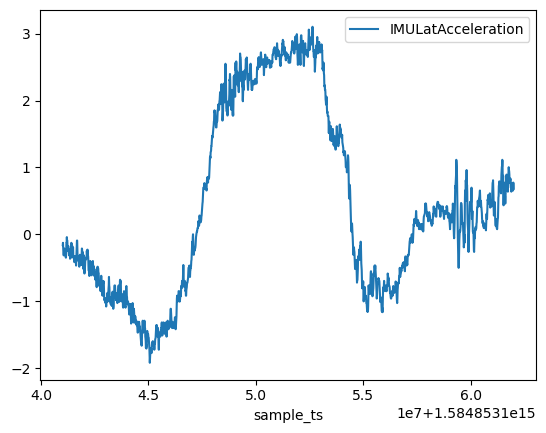

In [773]:
print(metadf.describe())
print(oridf.describe())

oridf.plot(x='ts',y=['IMULatAcceleration'])
metadf.plot(x='sample_ts',y=['IMULatAcceleration'])
# newdf=oridf['IMULatAcceleration']-metadf['IMULatAcceleration']
# oridf['IMULatAcceleration'].corr(metadf['IMULatAcceleration'])


In [774]:
def load_Speed_and_Heading_From_MetaDATA_then_calculate_and_plot(fileName,ts_key,heading_key,speed_key):
    df=pd.read_csv(fileName, sep=';', usecols = [ts_key,heading_key,speed_key])
    df = df.sort_values(by=[ts_key])
    start=False
    lastHeading=0
    deltaHeading=0
    currentHeading=365
    currentX=0
    currentY=0
    lastSpeedTS=0
    lastSpeed=0
    currentSpeed=0
    currentSpeedTS=0
    trace_df= pd.DataFrame(columns= [ts_key,'x_position','y_position'])
    for row in df.itertuples():
        if not pd.isna(row.northHeading):
            if not start:
                start = True
                lastSpeedTS=row.sample_ts
                lastHeading=row.northHeading
            lastHeading=currentHeading
            currentHeading=row.northHeading
            deltaHeading=currentHeading-lastHeading
            if deltaHeading<-300:
                currentHeading=-currentHeading-360
            if deltaHeading>300:
                currentHeading=currentHeading-360
        if not pd.isna(row.groundSpeed):
            if start:
                currentSpeed=row.groundSpeed
                currentSpeedTS=row.sample_ts
                delta_t=currentSpeedTS-lastSpeedTS
                delta_range=delta_t*(currentSpeed+lastSpeed)/2*1000/3600000000
                currentX=currentX+delta_range*math.cos(currentHeading/360)
                currentY= currentY+delta_range*math.sin(currentHeading/360)
                new_row = pd.Series({ts_key: currentSpeedTS, 'x_position':currentX,'y_position':currentY})
                trace_df=pd.concat([trace_df, new_row.to_frame().T], ignore_index=True)
                lastSpeed=currentSpeed
                lastSpeedTS=currentSpeedTS
    # plt.figure(figsize=(5,30))
    plt.scatter(x=trace_df['y_position'],y=trace_df['x_position'])
    plt.title(fileName[-11:-4]+' trace plot calculated by NorthHeading and speed')

    # return trace_df




        


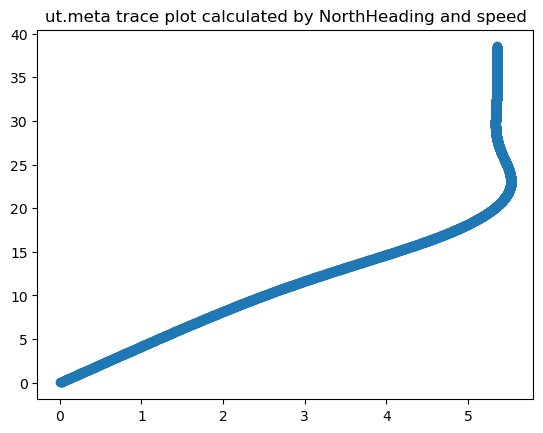

In [775]:
load_Speed_and_Heading_From_MetaDATA_then_calculate_and_plot(SNOW_FOX_REFERENCE_METADATA,'sample_ts','northHeading','groundSpeed')


In [776]:
SNOW_FOX_DATA_PATH='SnowFox-Roundabout-Dataset/SnowFox-Roundabout-Dataset/data'

In [777]:
SNOW_FOX_METADATA_5HZ = SNOW_FOX_DATA_PATH+'/meta5Hz.csv'
SNOW_FOX_METADATA_10HZ = SNOW_FOX_DATA_PATH+'/meta10Hz.csv'
SNOW_FOX_METADATA_WITHOUTSTEERINGWHEELANGLE_20HZ = SNOW_FOX_DATA_PATH+'/meta20Hz.csv'

In [778]:
def convert_timestamp(file_Name,keys):
    cols= ['sampleTimeStamp.seconds','sampleTimeStamp.microseconds']+keys
    df = pd.read_csv (file_Name, sep=';', usecols = cols)
    
    df['sample_ts'] = (df['sampleTimeStamp.seconds']*1000000)+df['sampleTimeStamp.microseconds']
    df = df.drop(columns=['sampleTimeStamp.seconds', 'sampleTimeStamp.microseconds'])
    fc= df.pop('sample_ts')
    df.insert(0,'sample_ts',fc)
    return df

In [779]:
def load_selected_data_and_convert_timestamp(filePath,freq):
    filename='*'+str(freq)+'Hz.csv'
    csv_files = glob.glob(os.path.join(filePath, filename))
    meta_df= pd.DataFrame(columns=['sample_ts'])
    for file in csv_files:
        # print(file)
        if file.__contains__('Heading'):
            df = convert_timestamp(file,['northHeading'])
        if file.__contains__('Acceleration'):
            df = convert_timestamp(file,['IMULatAcceleration','IMULgtAcceleration','IMUVerAcceleration'])
        if file.__contains__('SteeringWheelAngle'):
            df = convert_timestamp(file,['SteeringWhlAngle'])
        if file.__contains__('AngularVelocities'):
            df = convert_timestamp(file,['IMURollRate','IMUYawRate'])
        if file.__contains__('Speed'):
            df = convert_timestamp(file,['groundSpeed'])
        if file.__contains__('GPS'):
            df = convert_timestamp(file,['lat','lon'])
        meta_df=meta_df.merge(df,'outer','sample_ts')
    meta_df.to_csv(r''+filePath+'/meta'+str(freq)+'Hz.csv', sep=';', index = False)


        


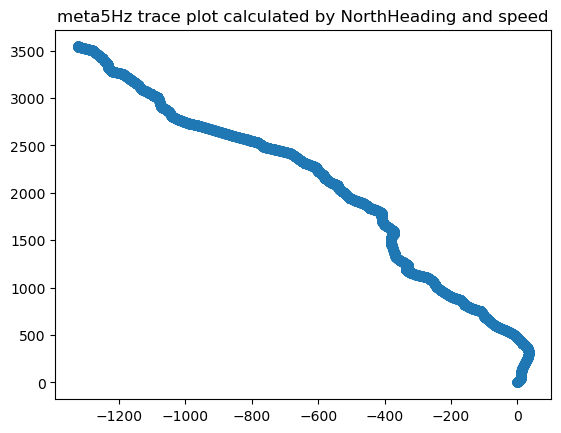

In [780]:
load_Speed_and_Heading_From_MetaDATA_then_calculate_and_plot(SNOW_FOX_METADATA_5HZ,'sample_ts','northHeading','groundSpeed')


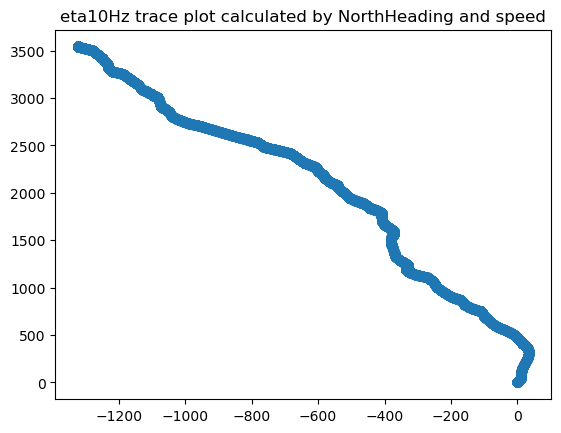

In [781]:
load_Speed_and_Heading_From_MetaDATA_then_calculate_and_plot(SNOW_FOX_METADATA_10HZ,'sample_ts','northHeading','groundSpeed')


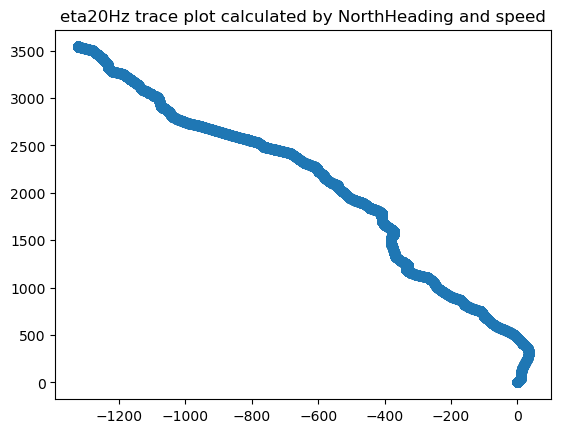

In [782]:
load_Speed_and_Heading_From_MetaDATA_then_calculate_and_plot(SNOW_FOX_METADATA_WITHOUTSTEERINGWHEELANGLE_20HZ,'sample_ts','northHeading','groundSpeed')


In [783]:
def load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot(fileName,ts_key,yawrate_key,speed_key):
    df=pd.read_csv(fileName, sep=';', usecols = [ts_key,yawrate_key,speed_key])
    df = df.sort_values(by=[ts_key])
    start=False
    currentYawRate=0
    currentRadius=0
    lastSpeedTS=0
    lastSpeed=0
    currentSpeed=0
    currentSpeedTS=0
    radius_df= pd.DataFrame(columns= [ts_key,'RadiusOfTurn'])
    for row in df.itertuples():
        if not pd.isna(row.IMUYawRate):
            if not start:
                start = True
                lastSpeedTS=row.sample_ts
            currentYawRate=row.IMUYawRate
        if not pd.isna(row.groundSpeed):
            if start:
                currentSpeed=row.groundSpeed
                currentSpeedTS=row.sample_ts
                currentRadius=(currentSpeed+lastSpeed)/2*1000/3600*math.sin(currentYawRate)*30
                new_row = pd.Series({ts_key: currentSpeedTS, 'RadiusOfTurn':currentRadius})
                radius_df=pd.concat([radius_df, new_row.to_frame().T], ignore_index=True)
                lastSpeed=currentSpeed
                lastSpeedTS=currentSpeedTS
    plt.scatter(x=radius_df['RadiusOfTurn'],y=radius_df[ts_key],s=0.1)
    plt.title(fileName[-11:-4]+' Radius Of Turn plot calculated by Yawrate and speed')


    # return trace_df




        


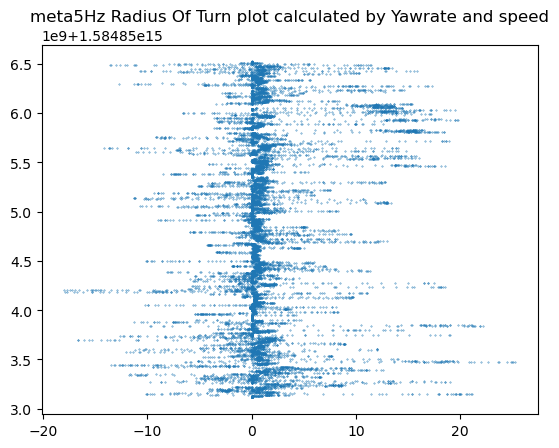

In [784]:
load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot(SNOW_FOX_METADATA_5HZ,'sample_ts','IMUYawRate','groundSpeed')


In [785]:
yaw_df= pd.read_csv(SNOW_FOX_METADATA_5HZ, sep=';', usecols = ['IMUYawRate'])
yaw_df.describe()


,IMUYawRate
count,16964.000000
mean,0.039196
std,0.124757
min,-0.514893
25%,0.009521
50%,0.017334
75%,0.031982
max,0.624756


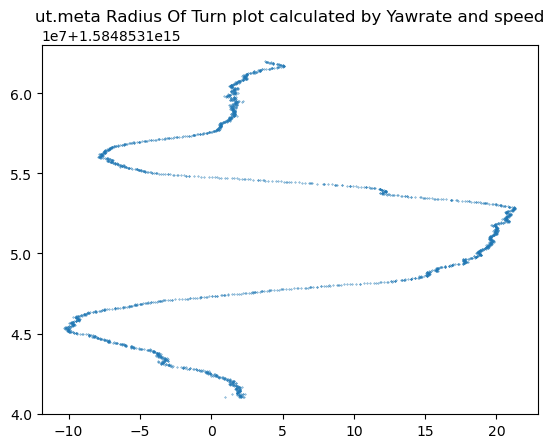

In [786]:
load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot(SNOW_FOX_REFERENCE_METADATA,'sample_ts','IMUYawRate','groundSpeed')


In [787]:
def load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot_with_latAcceleration(fileName,ts_key,yawrate_key,speed_key,accel_key,plot_vsize=5):
    df=pd.read_csv(fileName, sep=';', usecols = [ts_key,yawrate_key,speed_key,accel_key])
    df = df.sort_values(by=[ts_key])
    start=False
    currentYawRate=0
    currentRadius=0
    lastSpeedTS=0
    lastSpeed=0
    currentSpeed=0
    currentSpeedTS=0
    currentAccel=0
    radius_df= pd.DataFrame(columns= [ts_key,'RadiusOfTurn'])
    for row in df.itertuples():
        
        if not pd.isna(row.IMUYawRate):
            if not start:
                start = True
                lastSpeedTS=row.sample_ts
            currentYawRate=row.IMUYawRate
            if start:
                currentYawRate=row.IMUYawRate
        if not pd.isna(row.IMULatAcceleration):
            if start:
                currentAccel=row.IMULatAcceleration
        if not pd.isna(row.groundSpeed):
            if start:
                currentSpeed=row.groundSpeed
                currentSpeedTS=row.sample_ts
                if currentYawRate!=0:
                    currentRadius=(currentSpeed+lastSpeed)/2*1000/3600/(currentYawRate*3.14*2)
                else:
                    currentRadius=np.Infinity
                new_row = pd.Series({ts_key: currentSpeedTS, 'RadiusOfTurn':currentRadius,'Lat_accel':currentAccel,'IMUYawRate':currentYawRate,'Speed':currentSpeed})
                radius_df=pd.concat([radius_df, new_row.to_frame().T], ignore_index=True)
                lastSpeed=currentSpeed
                lastSpeedTS=currentSpeedTS
    # radius_df.dropna()
    plt.figure(figsize=(5,plot_vsize))
    plt.xlim(-3,3)
    plt.axvline(x=0,color="r")

    plt.axvline(x=1,color="y")

    # plt.axvline(x=2.5,color="y")
    # plt.axvline(x=5,color="y")
    # plt.axvline(x=10,color="y")
    # plt.axvline(x=15,color="y")
    # plt.axvline(x=20,color="y")
    plt.axvline(x=-1,color="y")
    # plt.axvline(x=-2.5,color="y")
    # plt.axvline(x=-5,color="y")
    # plt.axvline(x=-10,color="y")
    # plt.axvline(x=-10,color="y")
    # plt.axvline(x=-20,color="y")


    base=plt.subplot(111)
    # base.scatter(x=radius_df['Lat_accel'],y=radius_df[ts_key],s=0.1,c='r')
    # base.scatter(x=radius_df['IMUYawRate'],y=radius_df[ts_key],s=0.1,c='g')
    base.scatter(x=radius_df['RadiusOfTurn'],y=radius_df[ts_key],s=0.1,c='b')
    # base.scatter(x=radius_df['Speed'],y=radius_df[ts_key],s=0.1,c='purple')

    secax=base.twiny()
    # # secax.scatter(x=radius_df['Lat_accel'],y=radius_df[ts_key],s=0.1,c='b')
    secax.scatter(x=radius_df['IMUYawRate'],y=radius_df[ts_key],s=0.1,c='g')
    # secax.scatter(x=radius_df['RadiusOfTurn'],y=radius_df[ts_key],s=0.1,c='r')

    print(radius_df['IMUYawRate'])
    plt.title(fileName[-11:-4]+' Radius Of Turn plot calculated by Yawrate and speed')

    return radius_df




        


0       0.024170
1       0.023438
2       0.025146
3       0.026855
4       0.024170
          ...   
2088    0.065430
2089    0.063477
2090    0.064453
2091    0.065430
2092    0.062500
Name: IMUYawRate, Length: 2093, dtype: float64


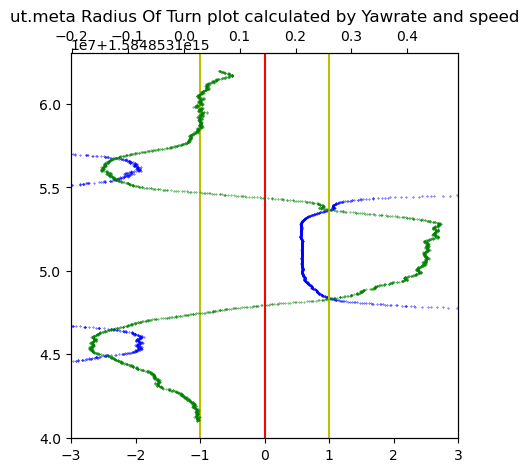

In [788]:
rf_df=load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot_with_latAcceleration(SNOW_FOX_REFERENCE_METADATA,'sample_ts','IMUYawRate','groundSpeed','IMULatAcceleration')


-5279951.0

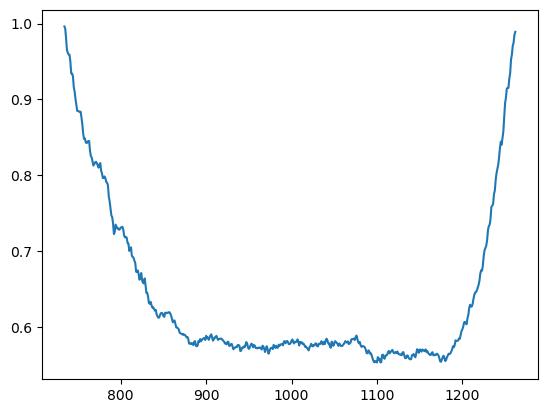

In [789]:
rf_filterd=rf_df[(rf_df['RadiusOfTurn']>0) & (rf_df['RadiusOfTurn']<1)]
rf_filterd
rf_filterd['RadiusOfTurn'].plot()
timespan= rf_filterd['sample_ts'].iloc[0]-rf_filterd['sample_ts'].iloc[-1]
timespan




-12410648.0

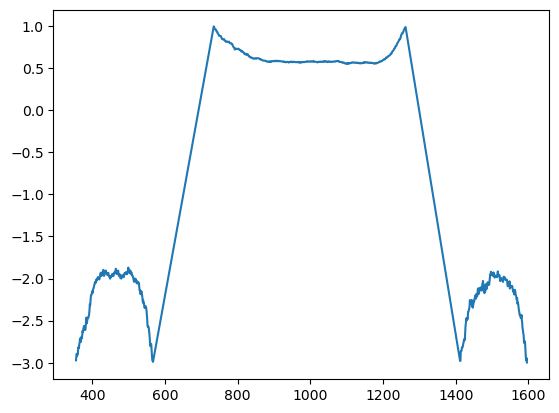

In [790]:
rf_filterd2=rf_df[(rf_df['RadiusOfTurn']>-3) & (rf_df['RadiusOfTurn']<1)]
rf_filterd2
rf_filterd2['RadiusOfTurn'].plot()
timespan2= rf_filterd2['sample_ts'].iloc[0]-rf_filterd2['sample_ts'].iloc[-1]
timespan2

0        0.020020
1        0.017334
2        0.020752
3        0.018066
4        0.016357
           ...   
16958    0.015625
16959    0.019043
16960    0.018066
16961    0.017334
16962    0.017334
Name: IMUYawRate, Length: 16963, dtype: float64


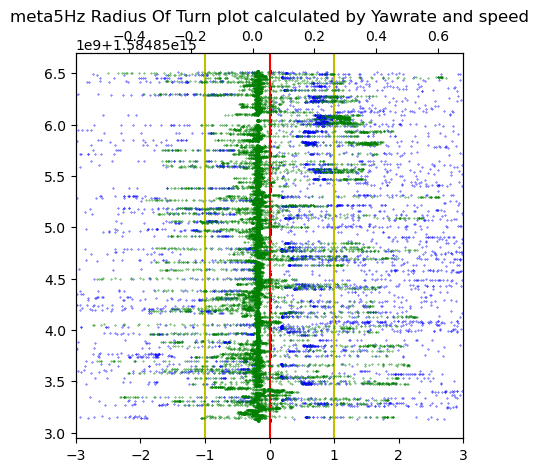

In [791]:
real_df=load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot_with_latAcceleration(SNOW_FOX_METADATA_5HZ,'sample_ts','IMUYawRate','groundSpeed','IMULatAcceleration')


,start,end
0,1584853148474918.0,1584853153675390.0
1,1584853472508823.0,1584853485758786.0
2,1584853840233726.0,1584853850693571.0
3,1584854125077455.0,1584854133927562.0
4,1584854690926553.0,1584854700146654.0
5,1584855088203333.0,1584855095533227.0
6,1584855293116385.0,1584855300716390.0
7,1584855464319793.0,1584855472689392.0
8,1584855803535727.0,1584855832495974.0
9,1584855922927452.0,1584855938238314.0


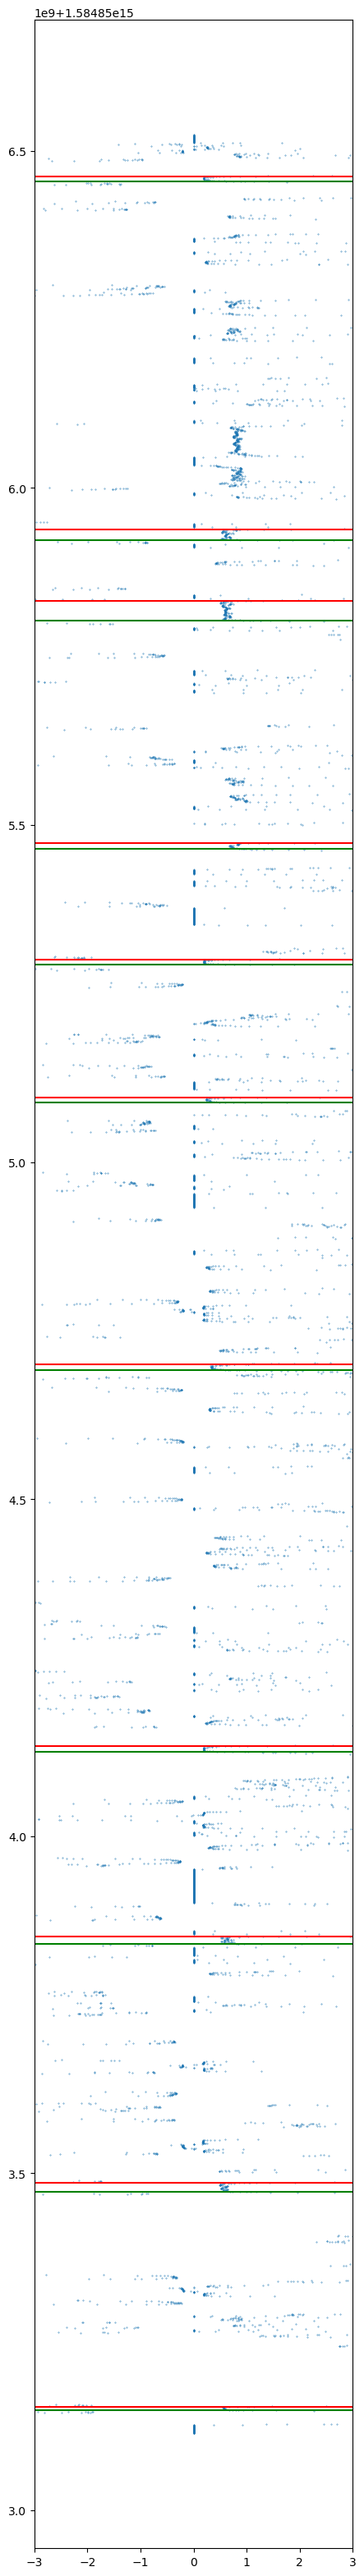

In [818]:
real_filterd2=real_df[(real_df['RadiusOfTurn']>-3)]

last_row_ts=0
ph1=False

periodList=pd.DataFrame(columns=['start','end'])
index=0
for row in real_filterd2.itertuples():
    if (row.RadiusOfTurn>0.5) and (row.RadiusOfTurn<1): 
        if ph1==False:

            ph1=True
            # print('start')
            periodList.at[index,'start']=row.sample_ts
    elif row.RadiusOfTurn>1:
        if ph1==True:
            # print('end')
            periodList.at[index,'end']=row.sample_ts
            index=index+1
            ph1=False
periodList=periodList[(periodList['end']-periodList['start'])>5000000]            
plt.figure(figsize=(5,40))
plt.xlim(-3,3)
plt.scatter(x=real_filterd2['RadiusOfTurn'],y=real_filterd2['sample_ts'],s=0.1)
count=0
result=pd.DataFrame(columns=['start','end'])
for i in periodList.itertuples():
    period=real_filterd2.loc[(real_filterd2['sample_ts']>=i.start) & (real_filterd2['sample_ts']<=i.end)]
    av_Yawrate=period['IMUYawRate'].mean()
    if av_Yawrate>0.3 :
        plt.axhline(i.start,c='g')
        plt.axhline(i.end,c='r')
        result.at[count,'start']=i.start
        result.at[count,'end']=i.end

        count=count+1
result        


0        0.020020
1        0.017334
2        0.020752
3        0.018066
4        0.016357
           ...   
16958    0.015625
16959    0.019043
16960    0.018066
16961    0.017334
16962    0.017334
Name: IMUYawRate, Length: 16963, dtype: float64


,sample_ts,RadiusOfTurn,Lat_accel,IMUYawRate,Speed
0,1.584853e+15,0.0,0.0000,0.020020,0.0
1,1.584853e+15,0.0,0.3485,0.017334,0.0
2,1.584853e+15,0.0,0.3485,0.020752,0.0
3,1.584853e+15,0.0,0.3825,0.018066,0.0
4,1.584853e+15,0.0,0.3825,0.016357,0.0
...,...,...,...,...,...
16958,1.584857e+15,0.0,-0.0255,0.015625,0.0
16959,1.584857e+15,0.0,-0.0255,0.019043,0.0
16960,1.584857e+15,0.0,0.0085,0.018066,0.0
16961,1.584857e+15,0.0,-0.0255,0.017334,0.0


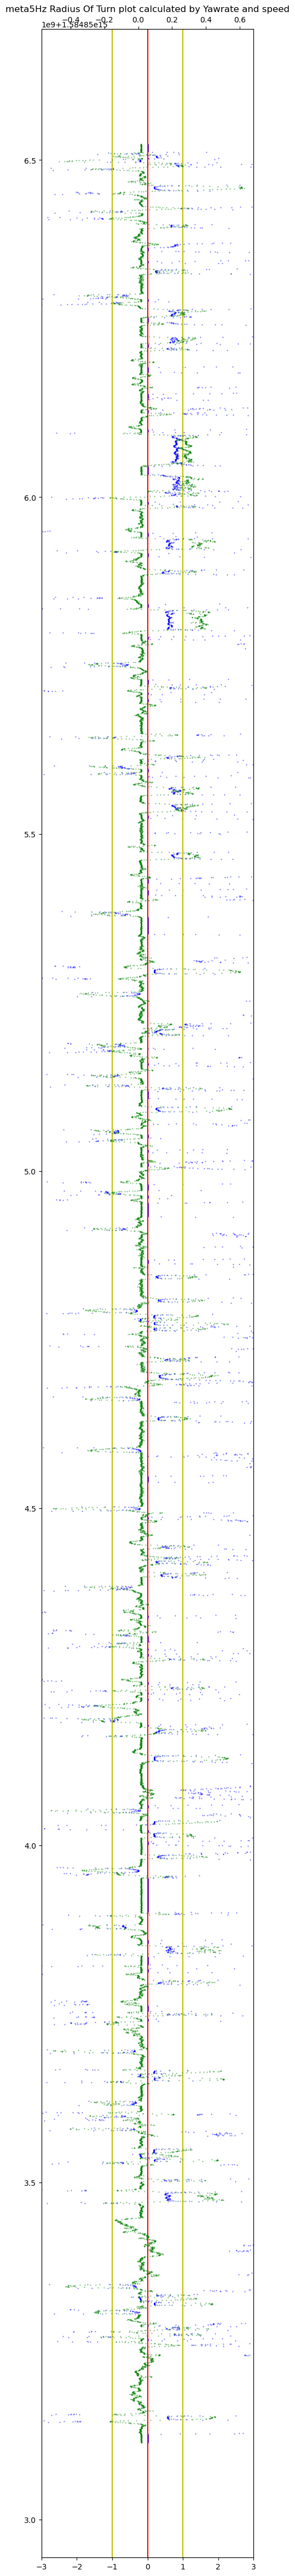

In [793]:
load_Speed_and_Yawrate_From_MetaDATA_then_calculate_radius_of_turn_and_plot_with_latAcceleration(SNOW_FOX_METADATA_5HZ,'sample_ts','IMUYawRate','groundSpeed','IMULatAcceleration',60)


In [794]:
m = morton.Morton(dimensions=2, bits=18)
def set_value(data,key1,key2):    
    return m.pack(round(data[key1]), round(data[key2]))


In [795]:
def load_data_encode_with_morton(data,key1,key2,offset1=0,offset2=0,multiplier1=1,multiplier2=1):
    df=data.dropna()
    df[key1+'modified']=df[key1].add(offset1)
    df[key2+'modified']=df[key2].add(offset2)
    df[key1+'modified']=df[key1+'modified'].multiply(multiplier1)
    df[key2+'modified']=df[key2+'modified'].multiply(multiplier2)
    
    df['morton']=df.apply(set_value,args=(key1+'modified',key2+'modified'),axis=1)
    return df


In [824]:
def load_METADATA_and_calculate_ROT_then_encode_with_morton_and_plot(fileName,ts_key,yawrate_key,speed_key,accel_key,offset1=0,offset2=0,multiplier1=1,multiplier2=1,plot_vsize=5,subplot=True):
    df=pd.read_csv(fileName, sep=';', usecols = [ts_key,yawrate_key,speed_key,accel_key])
    df = df.sort_values(by=[ts_key])
    start=False
    currentYawRate=0
    currentRadius=0
    lastSpeedTS=0
    lastSpeed=0
    currentSpeed=0
    currentSpeedTS=0
    currentAccel=0
    radius_df= pd.DataFrame(columns= [ts_key,'RadiusOfTurn'])
    for row in df.itertuples():
        if not pd.isna(row.IMUYawRate):
            if not start:
                start = True
                lastSpeedTS=row.sample_ts
            currentYawRate=row.IMUYawRate
            if start:
                currentYawRate=row.IMUYawRate
        if not pd.isna(row.IMULatAcceleration):
            if start:
                currentAccel=row.IMULatAcceleration
        if not pd.isna(row.groundSpeed):
            if start:
                currentSpeed=row.groundSpeed
                currentSpeedTS=row.sample_ts
                if currentYawRate!=0:
                    currentRadius=(currentSpeed+lastSpeed)/2*1000/3600/(currentYawRate*3.14*2)
                else:
                    currentRadius=np.Infinity
                new_row = pd.Series({ts_key: currentSpeedTS, 'RadiusOfTurn':currentRadius,'Lat_accel':currentAccel,'IMUYawRate':currentYawRate,'Speed':currentSpeed})
                radius_df=pd.concat([radius_df, new_row.to_frame().T], ignore_index=True)
                lastSpeed=currentSpeed
                lastSpeedTS=currentSpeedTS
    # radius_df.dropna()
    sfc_df=load_data_encode_with_morton(radius_df,'IMUYawRate','Speed',offset1,offset2,multiplier1,multiplier2)
    
    plt.figure(figsize=(5,plot_vsize))
    # plt.xlim(-3,3)
    if subplot==False:
        plt.xlim(2100,2200)

        plt.axvline(x=2150,color="r")
        plt.axvline(x=2110,color="y")


    # plt.axvline(x=1,color="y")
        base=plt.subplot(111)

        base.scatter(x=sfc_df['morton'],y=sfc_df[ts_key],s=0.5,c='g')
    # base.scatter(x=radius_df['Lat_accel'],y=radius_df[ts_key],s=0.1,c='r')
    # base.scatter(x=radius_df['IMUYawRate'],y=radius_df[ts_key],s=0.1,c='g')
    # base.scatter(x=radius_df['Speed'],y=radius_df[ts_key],s=0.1,c='purple')

    # secax.scatter(x=radius_df['Lat_accel'],y=radius_df[ts_key],s=0.1,c='b')
    # secax.scatter(x=radius_df['RadiusOfTurn'],y=radius_df[ts_key],s=0.1,c='r')
    else:
    
    
        fig,ax=plt.subplots(1,4,sharey=True)

        ax[0].scatter(x=sfc_df['RadiusOfTurn'],y=sfc_df[ts_key],s=0.1,c='b')
        ax[0].set_xlim(-3,3)
        ax[1].scatter(x=sfc_df['morton'],y=sfc_df[ts_key],s=0.1,c='g')
        ax[1].set_xlim(2100,2200)
        ax[1].axvline(x=2150,color="r")
        ax[1].axvline(x=2110,color="y")

        ax[2].scatter(x=sfc_df['RadiusOfTurn'],y=sfc_df[ts_key],s=0.1,c='b')
        ax[3].scatter(x=sfc_df['morton'],y=sfc_df[ts_key],s=0.1,c='g')

    # print(radius_df['IMUYawRate'])
    plt.title(fileName[-11:-4]+' Radius Of Turn plot calculated by Yawrate and speed and Morton')

<Figure size 500x500 with 0 Axes>

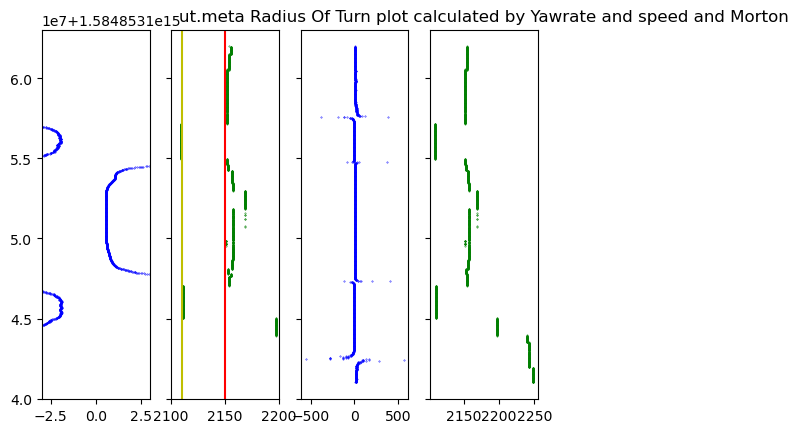

In [825]:
load_METADATA_and_calculate_ROT_then_encode_with_morton_and_plot(SNOW_FOX_REFERENCE_METADATA,'sample_ts','IMUYawRate','groundSpeed','IMULatAcceleration',1,32,multiplier1=8)

<Figure size 500x500 with 0 Axes>

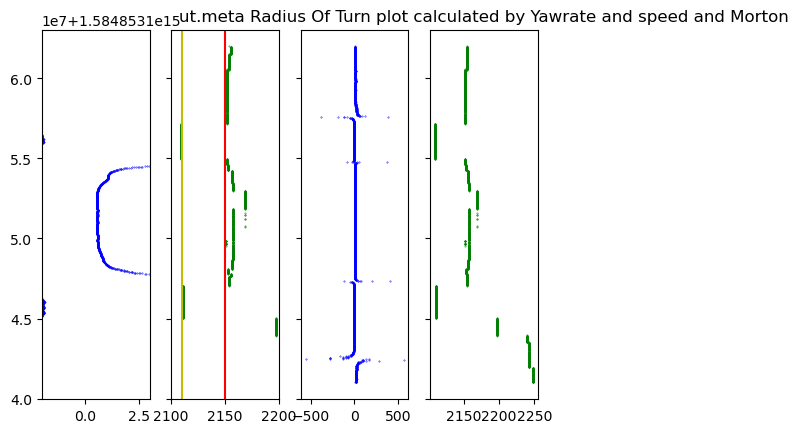

In [823]:
load_METADATA_and_calculate_ROT_then_encode_with_morton_and_plot(SNOW_FOX_REFERENCE_METADATA,'sample_ts','IMUYawRate','groundSpeed','IMULatAcceleration',1,32,multiplier1=8,plot_vsize=5,subplot=True)

<Figure size 500x6000 with 0 Axes>

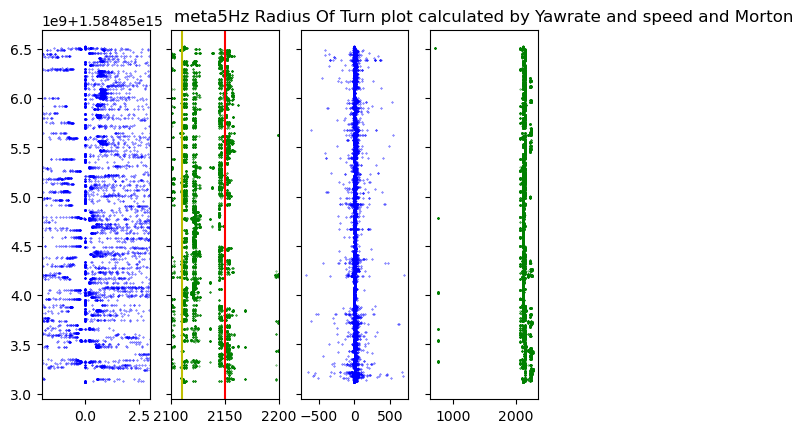

In [821]:
load_METADATA_and_calculate_ROT_then_encode_with_morton_and_plot(SNOW_FOX_METADATA_5HZ,'sample_ts','IMUYawRate','groundSpeed','IMULatAcceleration',1,32,multiplier1=8,plot_vsize=60,subplot=True)

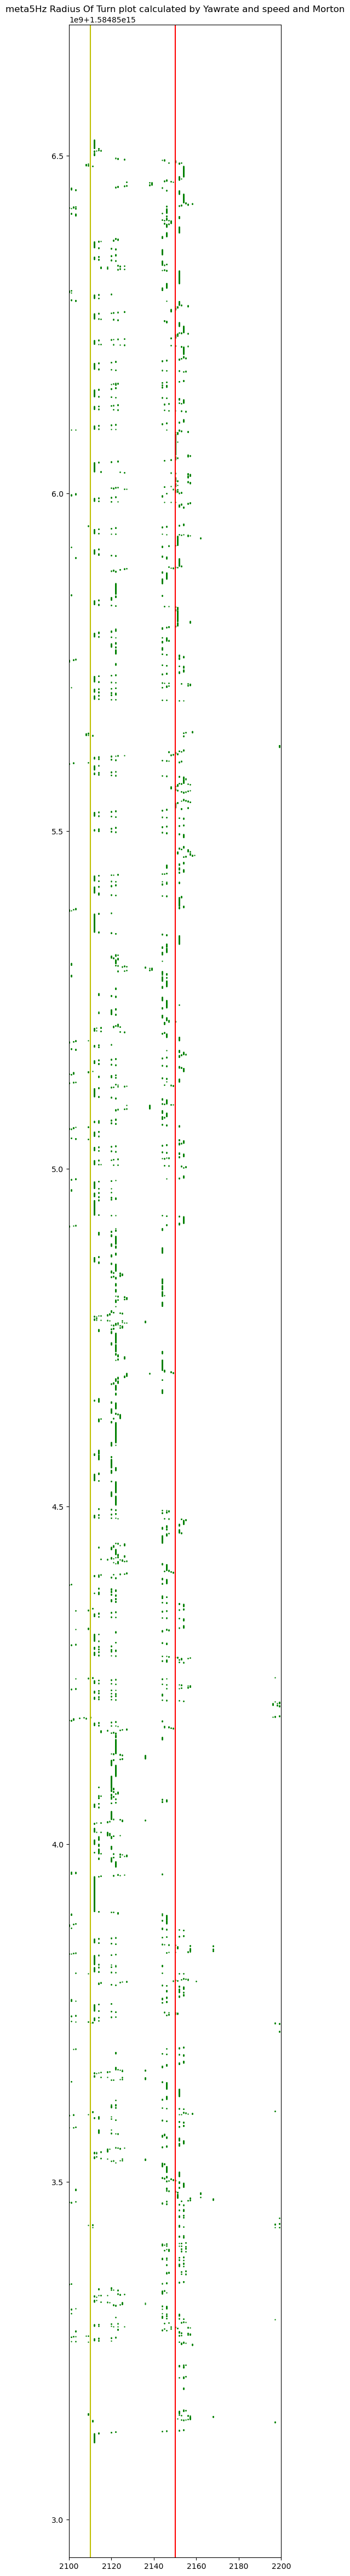

In [822]:
load_METADATA_and_calculate_ROT_then_encode_with_morton_and_plot(SNOW_FOX_METADATA_5HZ,'sample_ts','IMUYawRate','groundSpeed','IMULatAcceleration',1,32,multiplier1=8,plot_vsize=60,subplot=False)

In [ ]:
rf_df['Speed'].describe()